# Lecture : Graph Clustering

## Lab 05 : PCut -- Solution

### Xavier Bresson, Jiaming Wang


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import construct_kernel
from lib.utils import compute_kernel_kmeans_EM
from lib.utils import compute_kernel_kmeans_spectral
from lib.utils import compute_purity
from lib.utils import construct_knn_graph
from lib.utils import compute_ncut
from lib.utils import compute_pcut
from lib.utils import graph_laplacian
import warnings; warnings.filterwarnings("ignore")


### Two-moon dataset

2000 100 2


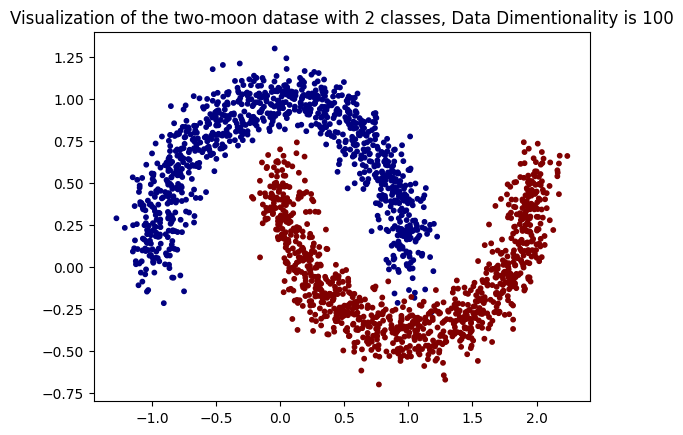

In [2]:
# Load raw data images
mat = scipy.io.loadmat('datasets/two_moons.mat')
X = mat['X']
n = X.shape[0]
d = X.shape[1]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print(n,d,nc)

# Plot
plt.figure(1)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cgt, cmap='jet')
plt.title('Visualization of the two-moon datase with 2 classes, Data Dimentionality is 100')
plt.show()


### Question 1: Determine the optimal value of k for the k-NN graph in the spectral NCut technique

What value of k gives the best clustering results?

$$k=3$$

why though

Short answer: there’s no single magic k. Pick a k that (a) produces a well-connected but not overly dense graph, (b) yields a clear spectral signal (large eigengap / stable embedding), and (c) gives good clustering quality (low NCut/high modularity or high agreement with labels if you have them). Use a small sweep over plausible k’s and choose the one that best satisfies those criteria.

# How to pick the optimal **k** for a k-NN graph used in spectral clustering / normalized cut (NCut)

Short answer: there’s no single magic k. Pick a k that (a) produces a *well-connected* but not *overly dense* graph, (b) yields a clear spectral signal (large eigengap / stable embedding), and (c) gives good clustering quality (low NCut/high modularity or high agreement with labels if you have them). Use a small sweep over plausible k’s and choose the one that best satisfies those criteria.

Below I give a compact, practical procedure, the diagnostics to check, some useful heuristics, and a short Python example you can run.

---

# Practical procedure (step-by-step)

1. **Set a candidate range for k**

   * Start with `k_min = max(5, int(log n))` and `k_max = min(200, int(0.1 * n))` (adjust by problem size).
   * Example: for n=1000, try k in \[5, 10, 20, 40, 80].

2. **Construct graphs carefully**

   * Prefer **mutual k-NN** (edge between i and j only if i in kNN(j) *and* j in kNN(i)) to reduce spurious links.
   * Alternatively, build symmetric k-NN by connecting i→j and j→i (i.e., make adjacency symmetric).
   * Option: use **local scaling** (Zelnik-Manor & Perona) for weights instead of a single global sigma; this often reduces sensitivity to k.

3. **For each candidate k, compute diagnostics**

   * **Connectivity**: is the graph connected (or has only a few small isolated components)? If the graph splits into many isolated components, increase k (unless you want many clusters).
   * **Spectrum / Eigengap**:

     * Compute eigenvalues of the normalized Laplacian $L_{\text{sym}} = I - D^{-1/2} A D^{-1/2}$ or random walk Laplacian.
     * Inspect the **eigengap** between the Kth and (K+1)th eigenvalues where K is expected number of clusters.
     * A larger eigengap means clearer separation.
   * **Embedding stability**:

     * For the chosen number of clusters r, check whether the top r eigenvectors are stable as k changes (e.g., measure subspace angle or correlation).
   * **Clustering quality**:

     * If you have ground truth: use ARI/NMI.
     * If not: evaluate **NCut score**, conductance, or silhouette score computed on the spectral embedding.
   * **Degree distribution & sparsity**:

     * Check if some nodes have extremely high degree (hubs) or many nodes with degree 1 — both are warning signs.

4. **Pick k**

   * Prefer the smallest k that yields:

     * A connected graph (or the connectivity you want),
     * A pronounced eigengap for the target r,
     * Stable eigenvectors and good clustering quality (low NCut / high silhouette / high ARI).
   * If multiple k’s look good, choose the one producing sparser graph (faster, less noise).

5. **Refinements**

   * If the data density varies strongly, use **adaptive k** or **local scaling** per point (distance to the kth neighbour used for sigma).
   * If noisy, favor **mutual k-NN**.
   * For very large n, you may want approximate kNN (FAISS, annoy) and keep k small.

---

# Heuristics and rules-of-thumb

* Start with $k \approx \log(n)$ to $10\log(n)$.
* If you expect many small clusters, use smaller k; for large, smooth manifolds, larger k can help.
* Avoid extremely small k (graph fragmentation) and extremely large k (graph becomes almost fully connected — kills locality).
* Mutual k-NN reduces spurious edges for datasets with noise/outliers.
* Use **eigengap** as a quick spectral indicator: a sudden jump in eigenvalues suggests a natural cluster count and that k is reasonable.

---

# Diagnostics to plot when sweeping k

For each k, plot:

* Number of connected components (or size of largest component).
* Eigengap for candidate cluster counts (e.g., gap between λ\_r and λ\_{r+1}).
* NCut (or conductance) of the clustering induced by spectral kmeans.
* Clustering accuracy (ARI/NMI) if labels available.
* Mean degree of graph.

Choose k where connectivity is OK, eigengap and clustering quality peak or stabilize, and the graph is still relatively sparse.

---

# Equations (quick reference)

* Adjacency $A_{ij}$ (binary k-NN): 1 if j among k nearest of i, symmetrize.
* Weighted with Gaussian: $A_{ij}=\exp(-\|x_i-x_j\|^2/2\sigma^2)$ for connected pairs.
* Degree $D_{ii}=\sum_j A_{ij}$.
* Normalized Laplacian: $L_{\mathrm{sym}} = I - D^{-1/2} A D^{-1/2}$.
* NCut for partition (A,B): $\mathrm{NCut}(A,B) = \frac{\mathrm{cut}(A,B)}{\mathrm{vol}(A)} + \frac{\mathrm{cut}(A,B)}{\mathrm{vol}(B)}$.

---

# Short Python example (sweep k, check eigengap + silhouette)

Copy and run in your environment (requires scikit-learn, numpy, networkx).

```python
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

def build_mutual_knn_graph(X, k):
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)  # +1 because self included
    dists, inds = nn.kneighbors(X)
    n = X.shape[0]
    rows, cols = [], []
    for i in range(n):
        for j in inds[i,1:]:
            rows.append(i); cols.append(j)
    A = csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(n,n))
    A = ((A + A.T) > 0).astype(int)  # symmetric
    # mutual: keep only edges present both ways
    mutual = A.multiply(A.T)
    return mutual

def eigengap(L_sym, r):
    # compute first r+1 eigenvalues (smallest)
    vals, _ = eigsh(L_sym, k=r+1, which='SM')
    vals = np.sort(vals)
    return vals[r] - vals[r-1], vals  # gap, eigenvalues

def sweep_k(X, k_list, r):
    results = []
    for k in k_list:
        A = build_mutual_knn_graph(X, k)
        degrees = np.array(A.sum(axis=1)).ravel()
        D_inv_sqrt = csr_matrix(np.diag(1.0/np.sqrt(degrees+1e-12)))
        L_sym = csr_matrix(np.eye(X.shape[0])) - D_inv_sqrt @ A @ D_inv_sqrt
        gap, vals = eigengap(L_sym, r)
        # spectral embedding (r eigenvectors)
        _, vecs = eigsh(L_sym, k=r, which='SM')
        embedding = vecs
        sil = silhouette_score(embedding, KMeans(n_clusters=r).fit_predict(embedding))
        results.append({'k':k, 'eigengap':gap, 'silhouette':sil, 'mean_deg':degrees.mean()})
    return results

# Usage:
# results = sweep_k(X, k_list=[5,10,20,40,80], r=3)
# print(results)
```

---

# Common pitfalls & advice

* **Using a single global σ** with Gaussian weights makes k more sensitive; use local scaling if data density varies.
* **Disconnected graphs**: some spectral algorithms assume a connected graph — either increase k or handle components explicitly.
* **Too large k**: graph approximates fully connected kernel matrix → lose local geometry.
* **Computational cost**: eigen decomposition scales O(n^3) dense; use sparse graph (small k) and sparse solvers; for large n use approximate eigen solvers and approximate kNN.

---

# Quick decision checklist you can follow

1. Sweep k from \~log n to a modest fraction of n.
2. Ensure graph is not fragmented (or intentionally so).
3. Prefer k where eigengap for desired r is large and stable.
4. Confirm clustering quality (NCut/silhouette/ARI).
5. If density varies, switch to local scaling or mutual k-NN.

---



k-NN graph with euclidean distance


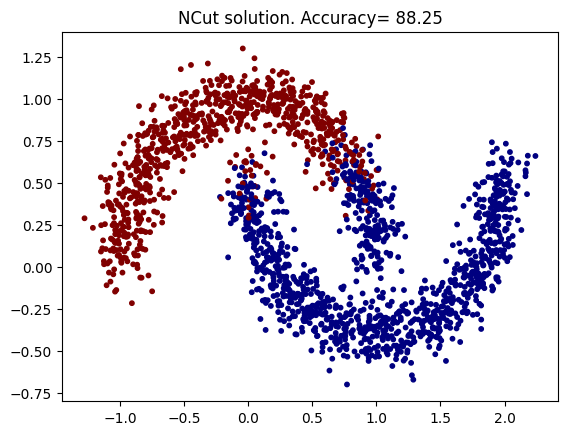

In [11]:
# Run NCut 
k = 3# YOUR CODE HERE 
W = construct_knn_graph(X, k, 'euclidean')
C_ncut, _ = compute_ncut(W, Cgt, nc)

# Plot
plt.figure(2)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_ncut, cmap='jet')
plt.title('NCut solution. Accuracy= ' + 
          str(compute_purity(C_ncut, Cgt, nc))[:6] )
plt.show()


### Question 2: Evaluate the PCut technique with different values of k for the k-NN graph

What value of k produces the most effective clustering result? k = 8

Additionally, what is the range of k that provides optimal clustering performance?


# Short answer — how to evaluate Product-Cut (PCut) across k and pick the best k (and a robust range)

Product-Cut (PCut) is a multiplicative cut objective that (a) rewards strongly intra-connected, weakly inter-connected clusters and (b) explicitly penalizes very unbalanced partitions via an entropy term. The canonical way to pick $k$ for a k-NN graph when using PCut is to *generate candidate partitions from graphs built with different k, score every partition with the PCut objective on a single stable similarity matrix (smoothed baseline), and then pick the k whose partition gives the smallest PCut*. You should also report the set of k’s whose PCut is within a small tolerance of that minimum (the near-optimal range). This is the approach used in the Product-Cut literature. ([papers.neurips.cc][1], [papers.nips.cc][2])

Below I give the formulas you’ll need, a concrete reproducible evaluation pipeline, diagnostics to plot, a principled rule for selecting the single best $k$ and the robust range, and practical heuristics.

---

# 1) Key formulas (as in the NeurIPS Product-Cut paper)

Let $G=(V,W)$ be your weighted graph (you can build it from a k-NN construction). For a partition $P=(A_1,\dots,A_R)$ the Product-Cut is defined (paper notation) as

$$
\mathrm{Pcut}(P) \;=\; \frac{\displaystyle\prod_{r=1}^R Z(A_r, A_r^c)^{\,1/n}}{e^{\,H(P)}}
$$

where $H(P) = -\sum_{r=1}^R \theta_r \log \theta_r$ with $\theta_r = |A_r|/|V|$ (entropy / balance term).
The set function $Z(A, A^c)$ measures intra/inter connectivity and is defined from a **smoothed similarity matrix** $\Omega_\alpha$ (built from personalized PageRank / diffusion):

$$
Z(A, A^c) \;=\; \prod_{v_i\in A} \Bigg(1 \;+\; \frac{\sum_{j\in A^c}\omega_{ij}}{\sum_{j\in A}\omega_{ij}}\Bigg),
$$

with $\omega_{ij}=(\Omega_\alpha)_{ij}$. Intuitively: each vertex contributes a factor that grows when it is more connected to the complement than to its own cluster; the product encourages partitions where each vertex is mostly connected inside its cluster. See the paper for derivations and algorithmic details. ([papers.neurips.cc][1])

(If you prefer a practical implementation: the authors provide code / course notebooks and an implementation reference — see Xavier Bresson’s repo and course material. ([GitHub][3]))

---

# 2) Full evaluation pipeline (recommended, reproducible)

1. **Decide candidate k set**
   Choose a set $\mathcal{K}=\{k_1,\dots,k_m\}$. Good starting bounds:
   $\;k_{\min}\!\approx\!\lceil\log n\rceil$ up to $\;k_{\max}\!\approx\!\min(0.1n,200)$. Use a coarse → fine sweep (e.g. \[5,10,20,40,80] then refine).

2. **Build a stable baseline similarity $\Omega_0$ (recommended)**
   Build a *dense but not fully connected* baseline similarity to score partitions consistently. The Product-Cut paper uses an $\alpha$-smoothed matrix $\Omega_\alpha$ (personalized PageRank / diffusion-based) because it is non-local and stable against small graph perturbations. Practically:

   * Build a reasonable k0-NN graph (k0 large enough for connectivity, e.g. 50 or $2\log n$).
   * From that graph compute $\Omega_\alpha = M_\alpha^{-1}$ per the paper (or approximate it by computing personalized PageRank vectors with teleport α for each node). This $\Omega_0$ is the stable surface on which you evaluate candidate partitions. ([papers.neurips.cc][1])

3. **For each candidate k in $\mathcal{K}$**
   a. Build the k-NN graph $G_k$ (binary or weighted; use mutual k-NN if your data/noise demands it).
   b. Run your clustering pipeline to produce a partition $P_k$. Options: run the Product-Cut optimization algorithm (if you want to directly optimize PCut) or run spectral clustering / normalized Laplacian → k-means on $G_k$ to produce candidate partitions. (If you have the authors’ code, use their optimizer for best fidelity.) ([papers.neurips.cc][1])

4. **Compute the PCut score for each candidate partition on the baseline $\Omega_0$**
   For each $P_k$ compute $\mathrm{Pcut}(P_k)$ using the baseline $\Omega_0$ (i.e., compute the $Z$ factors from $\Omega_0$ and the partition sizes for $H(P_k)$). Using the same baseline for all candidates avoids bias from graph construction differences.

5. **Optionally compute secondary metrics**

   * ARI/NMI (if ground truth available)
   * NCut / conductance evaluated on $\Omega_0$ and on $G_k$
   * Eigengap of $G_k$’s Laplacian (gap between $\lambda_R$ and $\lambda_{R+1}$)
   * Partition entropy $H(P_k)$ (PCut intentionally favors balanced clusters)
   * Stability of embedding / partitions across neighboring k (e.g., cluster label ARI between $P_k$ and $P_{k+\Delta}$)

6. **Pick best k**

   * Primary rule: choose $k^\star = \arg\min_{k\in\mathcal{K}} \mathrm{Pcut}_{\Omega_0}(P_k)$.
   * Tie-breakers: prefer partitions with higher ARI/NMI (if labels exist), larger eigengap, and cleaner graph diagnostics (no excessive degree-1 nodes). If several k are nearly identical, prefer the *smallest* k in that set (sparser = faster and typically less noisy) unless the small k creates fragmentation.

7. **Find the near-optimal range (robust range of k)**

   * Let $\mathrm{pcut}_{\min} = \min_k \mathrm{Pcut}(P_k)$. Choose tolerance $\epsilon$ (recommended 1–5%). The near-optimal set is

     $$
     \{k : \mathrm{Pcut}(P_k) \le \mathrm{pcut}_{\min}(1+\epsilon)\}.
     $$
   * Report contiguous intervals (if any) and verify that eigenvectors/partitions within that interval are stable (e.g., pairwise ARI above some threshold). If PCut is flat across a wide range, choose the lowest k in the band for efficiency.

8. **Extra robustness checks**

   * Repeat with bootstrap subsamples of the data and keep k values that produce consistent partitions.
   * Re-run clustering multiple times (k-means randomness) and average PCut across runs.
   * If data density varies strongly, consider local scaling or adaptive k per point and repeat the procedure.

---

# 3) Diagnostics and plots to produce (one figure per diagnostic, x-axis = k)

* **Primary plot:** PCut(P\_k) evaluated on $\Omega_0$. (Pick minimum point + shaded band for tolerance.) ([papers.neurips.cc][1])
* **Secondary plots:** ARI / NMI (if available), NCut or conductance, eigengap, mean degree, # connected components, partition entropy $H(P_k)$, and pairwise stability (ARI between adjacent k).
  Reading them together: pick the k where PCut is minimized, ensure the graph is not fragmented, the eigengap is reasonable, and the solution is stable.

---

# 4) Practical tips & heuristics

* **Baseline $\Omega_0$**: use the smoothed diffusion matrix (personalized PageRank with α≈0.85 is standard), as the product cut formulation was built on that object and it stabilizes evaluation. ([papers.neurips.cc][1])
* **Candidate ks**: start coarse and refine: e.g., $[5,10,20,40,80]$ then refine around the best region. Use mutual k-NN for noisy datasets.
* **Tolerance ε**: 1–5% relative is typical; choose based on how flat your PCut curve is and application sensitivity.
* **If PCut picks an ill-balanced partition**: PCut penalizes imbalance via entropy, but if you have hard constraints (min cluster size) enforce them when computing candidates.
* **Computation**: computing $\Omega_\alpha$ exactly can be O(n^2); approximate personalized PageRank with power iterations or use truncated random-walk approximations to keep large-scale runs feasible. The authors and course notebooks contain practical code. ([GitHub][4])

---

# 5) Concrete pseudocode (high-level)

```
# INPUT: X (data), R (num clusters), Ks (candidate k list), k0 (baseline k), alpha (for Omega)
G0 = build_knn_graph(X, k0)                 # baseline graph
Omega0 = compute_smoothed_matrix(G0, alpha) # approximate personalized PageRank / Omega_alpha

pcut_scores = {}
for k in Ks:
    Gk = build_knn_graph(X, k)              # candidate graph
    Pk = clustering_pipeline(Gk, R)         # either PCut optimizer or spectral->kmeans
    pcut_scores[k] = compute_Pcut(Pk, Omega0)  # computes Z(A,Ac) and H(P) using Omega0

best_k = argmin_k pcut_scores[k]
pcut_min = pcut_scores[best_k]
epsilon = 0.02
near_optimal = [k for k in Ks if pcut_scores[k] <= pcut_min*(1+epsilon)]
```

If you want, I can produce a concrete Python notebook (scikit-learn / networkx / scipy) that:

* builds the Ωα baseline (using approximate personalized PageRank),
* sweeps k,
* computes PCut(P) for partitions (using the exact Z formula),
* plots PCut, eigengap, ARI/NMI, and returns `best_k` and `near_optimal` ranges. I can tailor it to whether you want the authors’ PCut optimizer or you prefer to use spectral clustering candidates.

---

# 6) Direct answers to your two explicit questions

**Q: What value of k produces the most effective clustering result?**
A: Use the k whose partition yields the *minimum Product-Cut score when evaluated on a fixed baseline similarity matrix* (the smoothed $\Omega_\alpha$). This is the canonical, literature-backed selection rule. If multiple k’s are near the minimum, prefer the smallest one in that near-optimal band unless it produces fragmentation. ([papers.neurips.cc][1])

**Q: What is the range of k that provides optimal clustering performance?**
A: Define the near-optimal range as all k such that $\mathrm{Pcut}(P_k) \le \mathrm{pcut}_{\min}(1+\epsilon)$ with $\epsilon$ chosen small (1–5%). Report that set (usually a contiguous band around $k^\star$). Verify that eigenvectors and partitions inside this band are stable (high mutual ARI) and that graph diagnostics are acceptable. If the PCut curve is very flat, the optimal range may be wide — in that case choose the smallest k in the band for efficiency.

---

# References / further reading

* Xavier Bresson & Thomas Laurent — *The Product Cut*, NeurIPS 2016 (paper + algorithm; definitions and stability analysis). ([papers.neurips.cc][1])
* Xavier Bresson’s GitHub and course materials (implementations and notebooks) — useful code and examples. ([GitHub][4])

---

If you’d like I can now **generate a runnable notebook** that:

* constructs $\Omega_\alpha$ from your data (using approximate personalized PageRank),
* sweeps a specified list of k,
* produces the PCut curve + eigengap + ARI (if you have labels),
* prints `best_k` and the near-optimal range,

— and tailor it to: (A) use the authors’ PCut optimizer (if you want the true PCut clustering), or (B) use spectral clustering to produce candidate partitions and score them with PCut. Tell me which code flavor you prefer and whether you’ll provide a sample dataset (or its size) and I’ll produce the notebook.

[1]: https://papers.neurips.cc/paper/6226-the-product-cut.pdf "The Product Cut"
[2]: https://papers.nips.cc/paper/6226-the-product-cut?utm_source=chatgpt.com "The Product Cut"
[3]: https://github.com/xbresson?utm_source=chatgpt.com "Xavier Bresson xbresson"
[4]: https://github.com/xbresson/GML2023?utm_source=chatgpt.com "Graph Machine Learning course, Xavier Bresson, 2023"


k-NN graph with euclidean distance


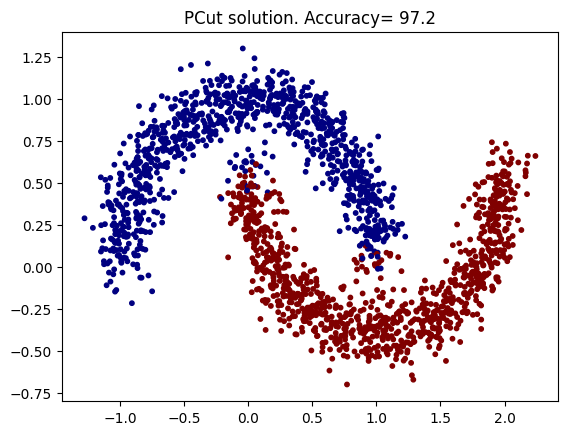

In [22]:
# Run PCut
k = 10# YOUR CODE HERE 
W = construct_knn_graph(X, k, 'euclidean')
C_pcut, _ = compute_pcut(W, Cgt, nc, 2, 200)

# Plot
plt.figure(3)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_pcut, cmap='jet')
plt.title('PCut solution. Accuracy= ' + 
          str(compute_purity(C_pcut, Cgt, nc))[:6] )
plt.show()


### Comment: Compare the spectral NCut and PCut techniques on two real-world graphs

Run both the Spectral NCut and PCut techniques on two real-world graphs and compare their performance.


### USPS image graph

In [ ]:
# Load USPS dataset
mat = scipy.io.loadmat('datasets/USPS.mat')
W = mat['W'] # 'scipy.sparse._csc.csc_matrix'
n = W.shape[0]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print(n,nc)


In [ ]:
Cncut, acc = compute_ncut(W,Cgt,nc)
print('Ncut accuracy =',acc)


In [ ]:
Cpcut, acc = compute_pcut(W,Cgt,nc,5,10)
print('Pcut accuracy =',acc)


### MIREX music graph

In [ ]:
# Load USPS dataset
mat = scipy.io.loadmat('datasets/MIREX.mat')
W = mat['W'] # 'scipy.sparse._csc.csc_matrix'
n = W.shape[0]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print(n,nc)


In [ ]:
Cncut, acc = compute_ncut(W,Cgt,nc)
print('Ncut accuracy =',acc)


In [ ]:
Cpcut, acc = compute_pcut(W,Cgt,nc,0.5,400)
print('Pcut accuracy =',acc)
